# Hands on Machine Learning (ML) and Sequential Learning (SP)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/AEM/blob/main/2-Hands_on_ML_SL.ipynb)

## Preamble

In this section we install and import the necessary modules for running the first part of the excersise (importing and handling data, training and validating the ML model, interpreting the ML model); we also define useful functions for materials featurization.

Installing with `pip` the necessary libraries (force the version with ==)

In [ ]:
%pip install pymatgen==2020.1.28
%pip install matminer==0.6.2
%pip install scikit_learn==0.22.2
%pip install shap==0.38.1

Importing the necessary modules

In [ ]:
import numpy as np
import pandas as pd
import shap
import sklearn
from matminer.featurizers import composition as cf
from matminer.featurizers.base import MultipleFeaturizer
from pymatgen import Composition
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

Defining functions for efficiently extracting materials features

In [ ]:
def get_compostion(c):
    """Function to get compositions from chemical formula using pymatgen"""
    try:
        return Composition(c)
    except:  # noqa: E722
        return None


def featurizing(data, property_interest=None):

    # Featurizer
    f = MultipleFeaturizer(
        [
            cf.Stoichiometry(),
            cf.ElementProperty.from_preset("magpie"),
            cf.ValenceOrbital(props=["avg"]),
            cf.IonProperty(fast=True),
        ]
    )

    # Inputs
    data["composition"] = [get_compostion(mat) for mat in data.Components]

    featurized_data = pd.DataFrame(
        f.featurize_many(data["composition"], ignore_errors=True),
        columns=f.feature_labels(),
        index=data["Components"],
    )
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

## Data handling

In this section we import the Superconductors database (two columns: brute formula and critical Temperature), extracting composition based features; we thus drop rows where at least a NaN (i.e., Not a Number) value occurs.

If you want to know the meaning of those 145 features, please check here https://www.nature.com/articles/npjcompumats201628?report=reader (and in the corresponding supplementary material, pdf). 

In brief, they are:
* **Stoichiometric attributes** that depend only on the fractions of elements present and not what those elements actually are
* **Elemental property statistics**, which are defined as the mean, mean absolute deviation, range, minimum, maximum and mode of 22 different elemental properties.
* **Electronic structure attributes**, which are the average fraction of electrons from the *s*, *p*, *d* and *f* valence shells between all present elements.
* **Ionic compound attributes** that include whether it is possible to form an ionic compound assuming all elements are present in a single oxidation state.


Downloading the database

In [ ]:
# source National Institute of Materials Science, Materials Information Station,
# SuperCon, http://supercon.nims.go.jp/index_en.html (2011)

!wget https://raw.githubusercontent.com/paolodeangelis/AEM/main/data/Supercon_data_clean.xlsx

In [ ]:
data = pd.read_excel(r"Supercon_data_clean.xlsx")  # Import data

'\nsource National Institute of Materials Science, Materials Information Station, \nSuperCon, http://supercon.nims.go.jp/index_en.html (2011)#\n'

In [ ]:
Featurized_data = featurizing(data, "Tc")  # Extract composition based features

MultipleFeaturizer: 100%|██████████| 12919/12919 [00:38<00:00, 335.77it/s]


In [ ]:
Featurized_data = Featurized_data.dropna()

In [ ]:
Featurized_data

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
H3S,2.0,0.790569,0.759147,0.750616,0.750049,0.750001,1.0,16.0,15.0,4.750000,...,46.500000,194.0,1.250000,1.000000,0.000000,0.000000,False,0.035456,0.006648,147.0
Ba100Ca99Cu145Hg33O420Pb17,6.0,0.574387,0.527459,0.516629,0.516020,0.515972,8.0,82.0,74.0,23.561425,...,104.430150,12.0,1.821867,2.105651,2.395577,0.859951,False,0.803211,0.165437,143.0
Ba1035Ca1035Cu1555Hg375O4104,5.0,0.572747,0.520734,0.507411,0.506507,0.506420,8.0,80.0,72.0,23.024062,...,104.234706,12.0,1.808119,2.025666,2.381540,0.647828,False,0.803211,0.167923,135.8
Ba2070Ca2070Cu3110Hg750O8187,5.0,0.572343,0.520183,0.506782,0.505868,0.505780,8.0,80.0,72.0,23.043553,...,104.237962,12.0,1.807871,2.023105,2.384630,0.648669,False,0.803211,0.167961,135.4
Ba200Ca200Cu300Hg100O829,5.0,0.571674,0.521679,0.509699,0.508967,0.508903,8.0,80.0,72.0,23.653775,...,103.279758,12.0,1.815838,2.035605,2.455494,0.859423,False,0.803211,0.166091,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As9Fe10La10O10P,5.0,0.488621,0.387712,0.322828,0.298729,0.282116,8.0,57.0,49.0,30.550000,...,74.282500,12.0,2.000000,1.750000,4.000000,0.000000,True,0.745613,0.122382,0.0
As200Ca81Ce19Fe100,4.0,0.596458,0.530189,0.504146,0.500683,0.500055,20.0,58.0,38.0,29.805000,...,29.125113,166.0,2.000000,1.500000,6.547500,0.047500,False,0.293972,0.048801,0.0
As18Fe20O20P2Pr13Sr7,6.0,0.458598,0.362455,0.305205,0.285416,0.272440,8.0,59.0,51.0,29.212500,...,75.774375,12.0,2.000000,1.750000,3.750000,0.487500,False,0.787757,0.124658,0.0


### **Data for the report**
Each group will perform the excercise with a different dataset. Your dataset will be obtained by picking 2000 rows from the original one (containing 12914 rows). The selection procedure of those rows is randomic; to ensure the *randomness reproducibility* we set a random state. The value of the random state has to be equal to the number of your group.

In [ ]:
# replace 0 with the number of your group
Featurized_data = Featurized_data.sample(n=2000, random_state=0)

In [ ]:
Featurized_data

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,Tc
Components,,,,,,,,,,,,,,,,,,,,,
CrV49,2.0,0.980204,0.980003,0.980000,0.980000,0.980000,23.0,24.0,1.0,23.020000,...,0.000000,229.0,1.980000,0.000000,3.040000,0.000000,False,0.000225,0.000004,4.08
CuS50Ta25,3.0,0.735666,0.684240,0.661956,0.658627,0.657959,16.0,73.0,57.0,34.921053,...,71.502770,70.0,1.986842,2.631579,1.118421,4.605263,False,0.252933,0.055853,4.20
Ba40Cu20Hg18O87Re2,5.0,0.595711,0.540726,0.523186,0.521284,0.520980,8.0,80.0,72.0,30.574850,...,100.298469,12.0,1.880240,2.083832,2.335329,1.676647,False,0.803211,0.167618,90.50
C10Ca30Cu20O71,4.0,0.612640,0.559579,0.543633,0.542182,0.541995,6.0,29.0,23.0,13.801527,...,103.183964,12.0,1.847328,2.320611,1.526718,0.000000,False,0.774266,0.156015,47.00
As125Fe125O112Pr125,4.0,0.500534,0.397682,0.331205,0.306518,0.289515,8.0,59.0,51.0,32.127310,...,65.286779,166.0,2.000000,1.689938,4.106776,0.770021,False,0.736585,0.116425,44.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
As50Rh21Ru29,3.0,0.614980,0.541352,0.507634,0.501724,0.500223,33.0,45.0,12.0,38.710000,...,20.510000,166.0,1.500000,1.500000,8.710000,0.000000,True,0.002497,0.000374,0.68
Ga9SnV30,3.0,0.783422,0.756699,0.750364,0.750023,0.750000,23.0,50.0,27.0,25.475000,...,58.987500,229.0,2.000000,0.275000,4.750000,0.000000,False,0.026858,0.001896,10.70
Bi2FLaOS4Sm,6.0,0.489898,0.423582,0.402774,0.400459,0.400039,8.0,83.0,75.0,36.600000,...,45.080000,70.0,2.000000,3.100000,2.100000,3.400000,False,0.874268,0.120964,4.05


## Machine Learning
In this section we train and validate a Random Forest Regressor for constructing a model which predicts the critical temperature of materials, on the basis of their chemical composition.

#### **Training and testing sets**
We split the 2000 rows long dataset (obtained in the previous section) in a training set (80% of 2000 rows = 1600 rows) and a testing set (20% of 2000 rows = 400 rows). The split is randomic. To ensure *randomness reproducibility* we set the usual random state. The value of the random state has to be equal to the number of your group.

In [ ]:
# replace 0 with the number of your group
train_df, test_df = train_test_split(
    Featurized_data, test_size=0.2, random_state=0
)  # split data in training set (80% of the dataset) and testing set (20% of the dataset)

#### **Machine Learning model definition**
As Machine Learning model for doing regression we choose a Random Forest Regressor.

* Since it is affected by randomness, we set the usual random state (it has to be equal to the number of your group).

* The only hyperparameter we consider is the number of estimators (number of trees is the forest). It has to be equal to 100

In [ ]:
rf = RandomForestRegressor(random_state=0, n_estimators=100)

#### **Model training**
We effectively train the model rf (defined in the previous cell) with the command ```rf.fit(X_training_set, y_training_set)```



In [ ]:
rf.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

#### **Model performances**
We compare the real critical temperature of the materials in the testing set, with the corresponding values predicted by the trained model.
We check those performances by means of three measures:
* coefficient of determination $R^2$, defined as
\begin{equation}
R^2(\mathbf{y}, {\mathbf{\hat{y}}}) = 1-\frac{\sum_{i=1}^k(y_i-\hat{y_i})^2}{\sum_{i=1}^k(y_i-\overline{y})^2}
\end{equation}
where $\mathbf{y}$ is the $k-$dimensional vector of real values, $\mathbf{\hat{y}}$ is the $k-$dimensional vector of predicted values, $\overline{y}=k^{-1}∑_{i=1}^ky_i$ is the average over real values. $R^2= 1$ if the prediction is perfect (i.e., all the red dots are on the blue line, with $y_i=\hat{y_i}, \forall i\in[1,\dots, k]$).

* Mean Absolute Error $\mathrm{MAE}$, defined as
\begin{equation}
\mathrm{MAE}(\mathbf{y}, {\mathbf{\hat{y}}}) = \frac{1}{k}\sum_{i=1}^k|y_i - \hat{y_i}|
\end{equation}
with the same meaning of the notation.

* Root Mean Squared Error $\mathrm{RMSE}$
\begin{equation}
\mathrm{RMSE}(\mathbf{y}, {\mathbf{\hat{y}}}) = \left(\frac{1}{k}\sum_{i=1}^k(y_i - \hat{y_i})^2 \right)^{1/2}
\end{equation}
with the same meaning of the notation.

In our case, $k$ is the length (i.e., the number of materials) of the testing set.

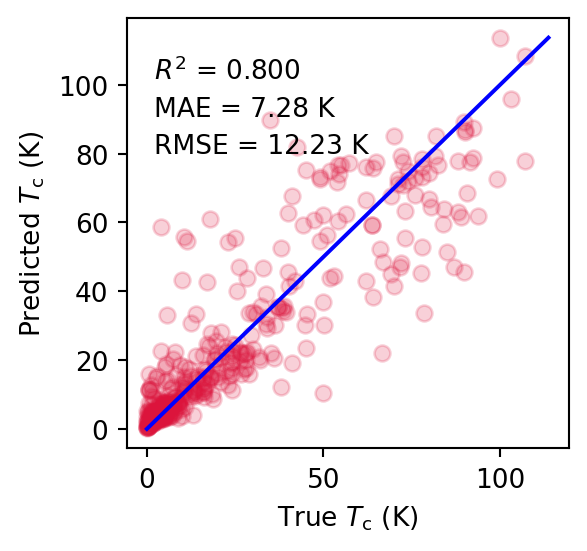

In [ ]:
test_predictions = rf.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error
delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel(r"True $T_\mathrm{c}$ (K)")
plt.ylabel(r"Predicted $T_\mathrm{c}$ (K)")
plt.show()

## Interpretability
Thanks to the TreeSHAP algorithm, we can find the most relevant features, ranking them in terms of importance with respect to the output.

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_df.iloc[:, :-1])

#### **Cumulative of normalized feature importances**
We produce the cumulative curve of normalized importances. The number of features explaining the 75% of the model is shown. 

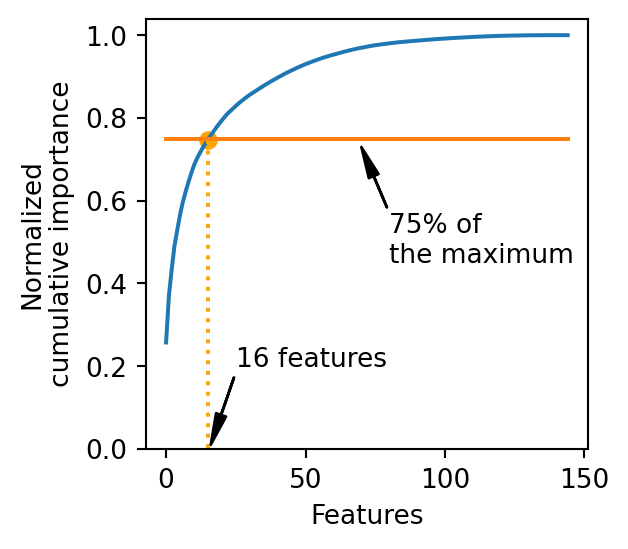

In [ ]:
N = np.shape(test_df.iloc[:, :-1])[1]
k = 0.75
import matplotlib.pyplot as plt

cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1])
normalized_cumulative = np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1]) / (
    np.max(np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1]))
)


fig, ax = plt.subplots(figsize=(3, 3), dpi=190)
ax.plot(np.arange(N), normalized_cumulative)
ax.plot(np.arange(N), k * np.ones(N))
ind_cross1 = np.argmin(
    np.fabs(normalized_cumulative - k * max(normalized_cumulative) * np.ones(N))
)
# plt.yticks(np.array([0, 0.5, 1]))

ax.annotate(
    "%i features" % (ind_cross1 + 1),
    xy=(ind_cross1 + 1, 0.01),
    xytext=(ind_cross1 + 10, 0.2),
    arrowprops=dict(facecolor="black", shrink=0.000005, width=0.1, headwidth=4),
)
ax.annotate(
    "75% of\nthe maximum",
    xy=(70, 0.73),
    xytext=(80, 0.45),
    arrowprops=dict(facecolor="black", shrink=0.0005, width=0.1, headwidth=4),
)
plt.scatter(ind_cross1, normalized_cumulative[ind_cross1], color="orange")
plt.plot(
    (ind_cross1, ind_cross1),
    (normalized_cumulative[ind_cross1], 0),
    color="orange",
    ls=":",
)
plt.ylim(0, 1.04)
plt.xlabel("Features")
plt.ylabel("Normalized\ncumulative importance")
plt.show()

#### **Ranking of normalized feature importances**
We produce the dataset "Output_mean_shap" containing the list of features sorted in terms of the corresponding importance. Sum of importances is 1.

In [ ]:
Output_shap = pd.DataFrame(
    shap_values, index=test_df.iloc[:, :-1].index, columns=test_df.iloc[:, :-1].columns
)
Output_mean_shap = pd.DataFrame(
    abs(Output_shap).describe().loc["mean"]
    / sum(abs(Output_shap).describe().loc["mean"])
).sort_values("mean", ascending=False)

In [ ]:
Output_mean_shap.to_excel(
    "Output_mean_shap.xlsx"
)  # list of the features ranked in terms of importance (importances sum up to 1)

## Sequential Learning
We compare three Sequential Learning acquisition functions to choose the next material to be tested, starting from an initial pool of known materials. 

As regression methodology over the training set, we consider the Random Forest Regressor by lolopy (which has nothing to do with the random forest regressor used for the predictive model in the previous sections).

In [ ]:
%pip install lolopy

In [ ]:
import tqdm
from lolopy.learners import RandomForestRegressor

In [ ]:
def MEI(X: np.ndarray, y: np.ndarray, n_steps: int) -> int:
    """Acquisition functions MEI.

    Args:
        X (numpy.ndarray): matrix with n rows (number of total materials for
            which doing the SL, in our case 100) and d columns (number of features
            taken into account for the optimization)
        y (numpy.ndarray): vector with n rows (target property)
        n_steps (int): number of steps allowed for doing SL (in our case,
            100 total materials - 50 materials in the initial training set
            = maximum 50 steps to find the optimum)

    Returns:
        int: the index of the chosen material
    """

    arr = y
    minima = arr.argsort()[0:50]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    F = np.zeros(n_steps)
    G = np.zeros(n_steps)
    mei_train = [list(set(np.where(in_train)[0].tolist()))]
    mei_train_inds = []

    T = 10

    for i in tqdm.tqdm(range(n_steps)):
        mei_train_inds = mei_train[-1].copy()
        mei_search_inds = list(all_inds.difference(mei_train_inds))

        mei_selection_index = []
        for j in range(T):
            model.fit(X[mei_train_inds], y[mei_train_inds])
            mei_y_pred_prov = model.predict(X[mei_search_inds])
            mei_selection_index.append(np.argmax(mei_y_pred_prov))

        mei_index_G = max(set(mei_selection_index), key=mei_selection_index.count)
        mei_index = mei_search_inds[mei_index_G]  # Pick the most preferred entry
        mei_train_inds.append(mei_search_inds[mei_index_G])
        mei_train.append(mei_train_inds)
        G[i] = mei_index
        F[i] = mei_train_inds[-1]
        if mei_train_inds[-1] == np.argmax(y):
            break

    return F


def MLI(X: np.ndarray, y: np.ndarray, n_steps: int) -> int:
    """Acquisition functions MLI.

    Args:
        X (numpy.ndarray): matrix with n rows (number of total materials for
            which doing the SL, in our case 100) and d columns (number of features
            taken into account for the optimization)
        y (numpy.ndarray): vector with n rows (target property)
        n_steps (int): number of steps allowed for doing SL (in our case,
            100 total materials - 50 materials in the initial training set
            = maximum 50 steps to find the optimum)

    Returns:
        int: the index of the chosen material
    """
    arr = y
    minima = arr.argsort()[0:50]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    K = np.zeros(n_steps)
    L = np.zeros(n_steps)
    mli_train = [list(set(np.where(in_train)[0].tolist()))]
    mli_train_inds = []

    T = 10

    for i in tqdm.tqdm(range(n_steps)):
        mli_train_inds = mli_train[-1].copy()
        mli_search_inds = list(all_inds.difference(mli_train_inds))

        mli_selection_index = []
        for j in range(T):
            model.fit(X[mli_train_inds], y[mli_train_inds])
            mli_y_pred_prov, mli_y_std_prov = model.predict(
                X[mli_search_inds], return_std=True
            )
            mli_selection_index.append(
                np.argmax(
                    np.divide(
                        mli_y_pred_prov - np.max(y[mli_train_inds]), mli_y_std_prov
                    )
                )
            )

        mli_index_L = max(set(mli_selection_index), key=mli_selection_index.count)
        mli_index = mli_search_inds[mli_index_L]  # Pick the most preferred entry

        mli_train_inds.append(mli_search_inds[mli_index_L])
        mli_train.append(mli_train_inds)
        L[i] = mli_index
        K[i] = mli_train_inds[-1]
        if mli_train_inds[-1] == np.argmax(y):
            break

    return K


def MU(X: np.ndarray, y: np.ndarray, n_steps: int) -> int:
    """Acquisition functions MU.

    Args:
        X (numpy.ndarray): matrix with n rows (number of total materials for
            which doing the SL, in our case 100) and d columns (number of features
            taken into account for the optimization)
        y (numpy.ndarray): vector with n rows (target property)
        n_steps (int): number of steps allowed for doing SL (in our case,
            100 total materials - 50 materials in the initial training set
            = maximum 50 steps to find the optimum)

    Returns:
        int: the index of the chosen material
    """

    arr = y
    minima = arr.argsort()[0:50]
    in_train = np.zeros(len(X), dtype=np.bool)
    in_train[minima] = True

    all_inds = set(range(len(y)))
    R = np.zeros(n_steps)
    S = np.zeros(n_steps)
    mu_train = [list(set(np.where(in_train)[0].tolist()))]
    mu_train_inds = []

    T = 10

    for i in tqdm.tqdm(range(n_steps)):
        mu_train_inds = mu_train[-1].copy()
        mu_search_inds = list(all_inds.difference(mu_train_inds))

        mu_selection_index = []
        for j in range(T):
            model.fit(X[mu_train_inds], y[mu_train_inds])
            mu_y_pred_prov, mu_y_std_prov = model.predict(
                X[mu_search_inds], return_std=True
            )
            mu_selection_index.append(np.argmax(mu_y_std_prov))

        mu_index_R = max(set(mu_selection_index), key=mu_selection_index.count)
        mu_index = mu_search_inds[mu_index_R]

        mu_train_inds.append(mu_search_inds[mu_index_R])
        mu_train.append(mu_train_inds)  # Pick the most preferred entry
        R[i] = mu_index
        S[i] = mu_train_inds[-1]
        if mu_train_inds[-1] == np.argmax(y):
            break

    return S

Replace your group number in the random_state below

In [ ]:
def produce_Data_SL(
    Data: pd.DataFrame,
    Output_mean_shap: pd.DataFrame,
    n_relevant: int,
    target_property: str,
) -> tuple:
    """Function to produce datasets for SL starting from the complete database (Featurized_data).

    Args:
        Data (pandas.DataFrame): complete database (Featureized_data)
        Output_mean_shap (pandas.DataFrame): ranking of features used in terms of importance
        n_relevant (int): number of relevant features
        target_property (str): name of the target property in the complete database

    Returns:
        tuple: containing:
            -  pandas.DataFrame: dataset with only the relevant features + the target property
            -  pandas.DataFrame: dataset with relevant features + set of unrelevant features
                (summing up to 30 columns) + the target property
    """

    relevant_features = list(Output_mean_shap.iloc[:n_relevant].index)
    unrelevant_features = list(
        Output_mean_shap.sort_values("mean").iloc[: int(30 - n_relevant)].index
    )
    all_features = relevant_features + unrelevant_features

    relevant_features.append(target_property)
    all_features.append(target_property)

    Data_sampled = Data.sample(
        n=100, random_state=0
    )  # replace the random_state with your group number

    Data_relevant_features = pd.DataFrame(Data_sampled, columns=relevant_features)
    Data_all_features = pd.DataFrame(Data_sampled, columns=all_features)

    return (Data_relevant_features, Data_all_features)

### **Definition of the SL predictor**
The SL predictor is constructed on the basis of the Random Forest Regressor by lolopy.

In [ ]:
model = RandomForestRegressor()

### **Datasets production for SL**
We produce two datasets:
* Data_relevant_features, with 100 random rows and the relevant features explaining the 75% of the predictive model (see section Interpretability) + target property column
* Data_all_features, with 100 random rows and 30 features, given by the relevant features (above point) + set of unrelevant features + target property column

In [ ]:
Data_relevant_features, Data_all_features = produce_Data_SL(
    Featurized_data, Output_mean_shap, ind_cross1 + 1, "Tc"
)

In [ ]:
Data_relevant_features.columns

Index(['MagpieData avg_dev SpaceGroupNumber', 'MagpieData avg_dev GSvolume_pa',
       'MagpieData mean NUnfilled', 'MagpieData avg_dev Column',
       'MagpieData mean MeltingT', 'MagpieData mode GSvolume_pa',
       'avg ionic char', 'MagpieData range Column',
       'MagpieData avg_dev Electronegativity', 'MagpieData range NValence',
       'MagpieData avg_dev NUnfilled', 'max ionic char',
       'MagpieData avg_dev GSmagmom', 'MagpieData avg_dev NdValence',
       'MagpieData mean NValence', 'MagpieData mean GSvolume_pa', 'Tc'],
      dtype='object')

In [ ]:
Data_all_features.columns

Index(['MagpieData avg_dev SpaceGroupNumber', 'MagpieData avg_dev GSvolume_pa',
       'MagpieData mean NUnfilled', 'MagpieData avg_dev Column',
       'MagpieData mean MeltingT', 'MagpieData mode GSvolume_pa',
       'avg ionic char', 'MagpieData range Column',
       'MagpieData avg_dev Electronegativity', 'MagpieData range NValence',
       'MagpieData avg_dev NUnfilled', 'max ionic char',
       'MagpieData avg_dev GSmagmom', 'MagpieData avg_dev NdValence',
       'MagpieData mean NValence', 'MagpieData mean GSvolume_pa',
       'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap',
       'MagpieData mode NfUnfilled', 'MagpieData minimum GSmagmom',
       'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled',
       'MagpieData maximum NsValence', 'MagpieData minimum NpValence',
       'MagpieData mode NfValence', 'MagpieData minimum NdValence',
       'MagpieData minimum Row', 'MagpieData range NsValence',
       'MagpieData minimum NsValence', 'MagpieData mod

![https://raw.githubusercontent.com/paolodeangelis/AEM/main/img/Image_Data.png](https://raw.githubusercontent.com/paolodeangelis/AEM/main/img/Image_Data.png)

#### **Sequential Learning relevant features**
Start with the pool of the 50 worst samples in terms of the target $y$ (critical Temperature); SL strategies suggest the next material to be evaluated. The objective is to find the optimum among the other 50 materials with as few evaluations as possible. Search stops when the material with the maximum $y$ (among those remaining 50) is chosen. 

Three strategies are compared: Maximum Expected Improvement (MEI), Maximum Likelihood Improvement (MLI), Maximum Uncertainty (MU).

<div class="alert alert-block alert-warning">
<b>WARNING: </b> 

Since also the Random Forest Regressor by lolopy for SL is not deterministic, if you run the code more times, you will end up with different *trajectories* of evaluations.
</div>

![https://raw.githubusercontent.com/paolodeangelis/AEM/main/img/Image_SL.png](https://raw.githubusercontent.com/paolodeangelis/AEM/main/img/Image_SL.png)

In [ ]:
MEI_index_relevant = MEI(
    Data_relevant_features.iloc[:, :-1].values,
    Data_relevant_features.iloc[:, -1].values,
    50,
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 10%|█         | 5/50 [00:07<01:05,  1.45s/it]


In [ ]:
MLI_index_relevant = MLI(
    Data_relevant_features.iloc[:, :-1].values,
    Data_relevant_features.iloc[:, -1].values,
    50,
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 20%|██        | 10/50 [00:07<00:28,  1.38it/s]


In [ ]:
MU_index_relevant = MU(
    Data_relevant_features.iloc[:, :-1].values,
    Data_relevant_features.iloc[:, -1].values,
    50,
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 14%|█▍        | 7/50 [00:04<00:25,  1.68it/s]


#### **Sequential Learning relevant + unrelevant features**
Start with the pool of the 50 worst samples in terms of the target $y$ (critical Temperature); SL strategies suggest the next material to be evaluated. The objective is to find the optimum among the other 50 materials with as few evaluations as possible. Search stops when the material with the maximum $y$ (among those remaining 50) is chosen. 

Three strategies are compared: Maximum Expected Improvement (MEI), Maximum Likelihood Improvement (MLI), Maximum Uncertainty (MU).

<div class="alert alert-block alert-warning">
<b>WARNING: </b> 

Since also the Random Forest Regressor by lolopy for SL is not deterministic, if you run the code more times, you will end up with different *trajectories* of evaluations. 
</div>

In [ ]:
MEI_index_all = MEI(
    Data_all_features.iloc[:, :-1].values, Data_all_features.iloc[:, -1].values, 50
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 20%|██        | 10/50 [00:08<00:33,  1.18it/s]


In [ ]:
MLI_index_all = MLI(
    Data_all_features.iloc[:, :-1].values, Data_all_features.iloc[:, -1].values, 50
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 18%|█▊        | 9/50 [00:08<00:36,  1.11it/s]


In [ ]:
MU_index_all = MU(
    Data_all_features.iloc[:, :-1].values, Data_all_features.iloc[:, -1].values, 50
)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 14%|█▍        | 7/50 [00:05<00:33,  1.27it/s]


#### **Comprehensive comparison between more strategies and different sets of features**
We plot the performances of the SL in terms of the number of evaluations needed to find the optimum normalized with respect to the average number of evaluations needed with a *naive* random choice.

Replace the numbers 19, 12, ..., with the numbers of evaluations performed by SL in your runs.

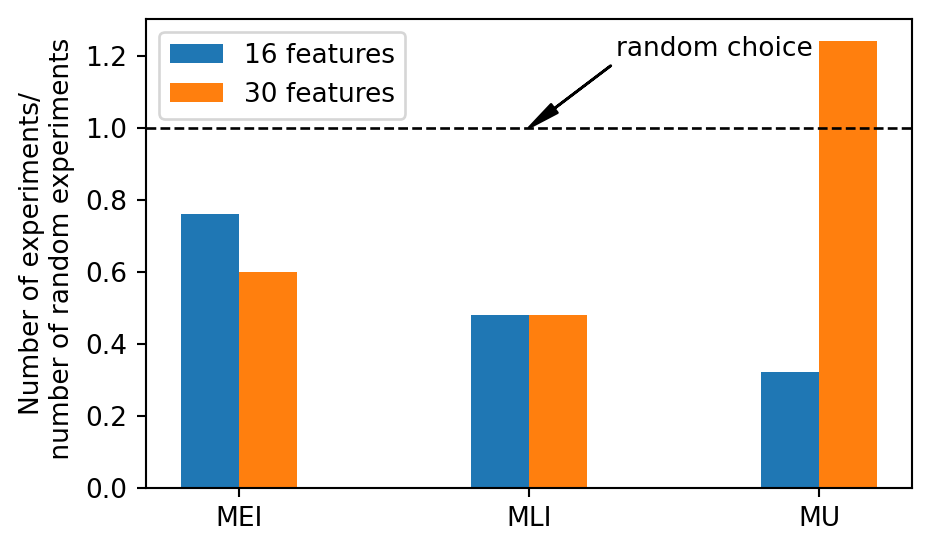

In [ ]:
N = 50 / 2  # number of evaluations in random choice
labels = ["MEI", "MLI", "MU"]
relevant = [
    19 / N,
    12 / N,
    8 / N,
]  # replace numbers with the numbers of evaluations performed by SL for MEI, MLI, MU with only relevant features
all = [
    15 / N,
    12 / N,
    31 / N,
]  # replace numbers with the numbers of evaluations performed by SL for MEI, MLI, MU with also unrelevant features

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3), dpi=190)

rects1 = ax.bar(x - width / 2, relevant, width, label="%i features" % (ind_cross1 + 1))
rects2 = ax.bar(x + width / 2, all, width, label="30 features")
plt.axhline(y=1, color="k", linewidth=1, linestyle="--")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of experiments/\n number of random experiments")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.annotate(
    "random choice",
    xy=(1, 1),
    xytext=(1.3, 1.2),
    arrowprops=dict(facecolor="black", width=0.1, headwidth=4),
)


fig.tight_layout()

plt.show()

## Assignment 
### Notebook
* In this notebook, whenever you see ```random_state = 0```, please replace 0 with the number of your group.
* In this notebook, after the SL runs, in the subsection "Comprehensive comparison between more strategies and different sets of features", please replace the number of evaluations (19, 12, 8, ...) with the ones that you obtain in your runs. Please notice that, since the code is not deterministic, if you run the same code more times, in general you will end up with different results. Don't worry: just report the number of evaluations of one run for each of the 6 cases (3 methodologies with 2 different sets of features).

### Report
* **First part**: with this notebook modified as prescribed above, obtain main results (model performances, relevant features, Sequential Learning performances).
* **Second part**: redo the *Machine Learning* section and the *Interpretability* section modifying the number of materials in the dataset and the number of estimators in the Random Forest Regressor (for the predictive model). Combinations of those parameters are provided for each group in the document "Assignments for the machine learning lab". For each combination, please, re-run the code from the SuperCon database import.



